## ResNet Constructor.
Данный ноутбук содержит контруктор ResNet подобных сетей и пайплайн для работы с ним.
- accuracy на тестовой части датасета Imagenette составляет 92,1%
- в pipeline'e реализовано сохранения метрик и модели 

### Oсновые блоки
[Загрузка датасета](#Загрузка-датасета) <br>
[Гиперпараметры обучения](#Гиперпараметры-обучения) <br>
[Просмотр датасета](#Просмотр-датасета) <br>
[Использование конструктора](#Использование-конструктора) <br>
[Тренировочный цикл](#Тренировочный-цикл) <br>
[Проверка модели](#Проверка-модели) <br>
[Критика](#Критика)

In [1]:
import time
import warnings
import os

import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision import transforms, datasets, utils
from fastai.vision.all import untar_data, URLs

from modules import datasets_loader, train_tools, CNN_constructor

warnings.filterwarnings('ignore')

### Загрузка датасета

In [2]:
dataset_path = '../imagenette/imagenette2-320/'
datasets_loader.imagenette_loader(dataset_path)

- для загрузки датасета нужно установить <b>fastai</b>. Команда для установки: <br>
'conda install -c fastai -c pytorch fastai'

### Гиперпараметры обучения

In [3]:
batch_size = 32
num_epoch = 400
learning_rate = 0.001
optimizer_type = 'Adam'
save_best_model = True

# resnet architecture
resnet_layers = [3, 4, 6, 3]
bottleneck = False
num_classes = 10

# learning_rate_decay
scheduler_type = 'cos'
cosine_cycles = 1
decay_steps = 5

save_model_dir = './models/'
metrics_dir = './metrics/'

torch.set_num_threads(8)

- batch_size: кол-во изображений в одном батче. Предел зависит от кол-ва памяти на видеокарте.
- num_epoch: кол-во эпох обучения.
- learning_rate: скорость обучения.
- optimizer_type: тип оптимизатора, использующегося для обновления весов сети. Может быть 'SGD' или 'Adam'.

<b>Архитектура сети:
 - layers - список с количеством ResNet блоков по c разбивкой по группам
 - num_classes - количество классов
 - bottleneck - определяет использование стандартных блоков или 'bottleneck' блоков <br>

(!) Конструктор ожидает на вход изображение с разрешением 224х224х3

Примеры стандартных архитектур:<br>
<b>ResNet-18: </b> <br> 
model = ResNet_like(layers=[2, 2, 2, 2], bottleneck=False, num_classes=10)

<b>ResNet-34: </b> <br> 
model = ResNet_like(resnet_layers=[3, 4, 6, 3], bottleneck=False, num_classes=10)

<b>ResNet-50: </b> <br> 
model = ResNet_like(resnet_layers=[3, 4, 6, 3], bottleneck=True, num_classes=10)

<b>ResNet-101: </b> <br> 
model = ResNet_like(resnet_layers=[3, 4, 23, 3], bottleneck=True, num_classes=10)

<b>ResNet-152: </b> <br> 
model = ResNet_like(resnet_layers=[3, 8, 36, 3], bottleneck=True, num_classes=10)
    
<b>Настройка изменения learning rate в течении обучения. </b><br> 
Реализовано две стратегии 'cos' - согласно функции косинуса и 'step' - ступенчатое уменьшение в 10 раз через равные промежутки.
- sheduler_type: задает стратегию изменения скорости обучения в течении обучения. может быть 'cos' или 'step'.
- cosine_cycles: задает кол-во циклов изменения learning rate. Должно быть меньше или равно num_epoch.<br> 
- decay_steps: количество шагов уменьшения learning rate при ступенчатом уменьшении ('step'). Должно быть меньше или равно num_epoch.<br> 

Прочее
- dataset_path: путь к папке с датасетом.
- save_model_dir: путь к папке, в которую сохраняются модели.
- metrics_dir: путь к папке, в которую сохраняется файл с метриками обучения.
------------

Задаем название модели, которое будет фигурировать в названии сохраненных файлов метрики и модели<br>
Название модели является производным от гиперпараметров

In [4]:
m = 3 if bottleneck else 2
n = cosine_cycles if scheduler_type == 'cos' else decay_steps
model_name = f'ResNet{sum(resnet_layers)*m + 2}_{optimizer_type}_lr{learning_rate}_b{batch_size}_{scheduler_type}_sc{(num_epoch-5)//n}'
print(f'model name is {model_name}')

model name is ResNet34_Adam_lr0.001_b32_cos_sc395


### Просмотр датасета

Посмотрим csv, приложенный к датасету

In [5]:
labels_df = pd.read_csv(dataset_path + '/noisy_imagenette.csv')
labels_df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False


В приложенном датасете указаны пути к картинкам и их лейблы. <br>
Цифра после noisy_labels_ означает уровень зашумленности правильных ответов, т.е. noisy_labels_25 означает, что 25% правильных ответов - неправильные.

В этом ноутбуке мы будем работать без зашумления правильных ответов, т.е. нас интересует колонка 'noisy_labels_0'. <br>
Давайте посмотрим сколько уникальных классов находится в этом датасете.

In [6]:
print('Unique labels in Imagenette is', len(labels_df['noisy_labels_0'].unique()))

Unique labels in Imagenette is 10


Кол-во картинок в тренировочном датасете

In [7]:
train_img_qty = len(labels_df[labels_df['is_valid'] == False].index)
print(f'Image in train dataset: {train_img_qty}')

Image in train dataset: 9469


Кол-во картинок в тестовом датасете

In [8]:
test_img_qty = len(labels_df[labels_df['is_valid'] == True].index)
print(f'Image in test dataset: {test_img_qty}')

Image in test dataset: 3925


Давайте глянем на примеры картинок в тренировочном датасете

gas pump


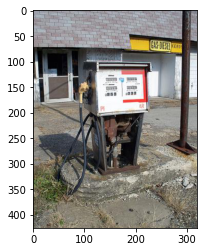

church


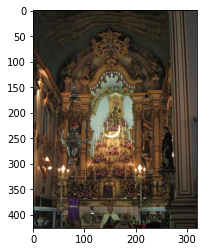

church


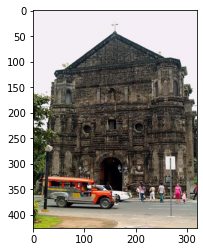

golf ball


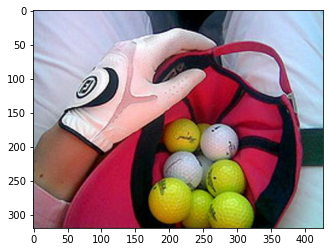

In [9]:
show_subset = datasets.ImageFolder(root=dataset_path + '/train/', transform=transforms.Compose([transforms.ToTensor()]))
show_subset = torch.utils.data.Subset(show_subset, np.random.randint(0,high=len(show_subset), size=4))
show_subset_loader = torch.utils.data.DataLoader(show_subset, shuffle=False)
for images, labels in show_subset_loader:
    print(datasets_loader.label_func(int(labels)))
    datasets_loader.visual_tensor(utils.make_grid(images))

### Создаем DataLoader попутно предобрабатывая данные

В качетсве аугментаций ипользуется:
- уменьшение картинки до разрешения 260*260
- вырезка случайного квадрата размером 224*224
- переворот изображения по горизонтальной оси
- нормализация

In [10]:
train_transform = transforms.Compose([
        transforms.Resize(260),
        transforms.RandomSizedCrop((224, 224)),
        transforms.RandomHorizontalFlip(.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

trainset = datasets.ImageFolder(root=dataset_path + '/train/', transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.ImageFolder(root=dataset_path + '/val/', transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=False)

## Создание модели<br>

Используем контруктор ResNet подобных сетей из модуля CNN_constructor для создания модели.

In [11]:
model = CNN_constructor.ResNetLike(layers=resnet_layers, bottleneck=bottleneck, num_classes=num_classes)

Задаем функцию потерь, оптимизатор и создаем планировщик изменения скорости обучения.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = train_tools.get_optimizer(model, optimizer_type, learning_rate)
scheduler = train_tools.get_scheduler(optimizer, scheduler_type, step_size=num_epoch//decay_steps, cycle_len=num_epoch//cosine_cycles)

Загружаем модель на видеокарту.

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:1


ResNetLike(
  (first): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (block_2_1): ResNetNormalBlock(
      (activation): ReLU()
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block_2_2): ResNetNormalBlock(
      (activation): ReLU()
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_s

Создадим папки для сохранения моделей и метрик

In [14]:
datasets_loader.create_dir(save_model_dir)
datasets_loader.create_dir(metrics_dir)

already created
already created


Создаем датафрейм для записи метрик обучения. <br>
Датафрейм сохраняется в папку './metrics'

In [15]:
cols_name = ['epoch', 'time', 'current_lr', 'loss', 'accuracy_train', 'accuracy_val']
metrics_frame = pd.DataFrame(columns=cols_name)
metrics_frame_file = (metrics_dir + model_name + '.csv')
print(f'File with train metrics save to {metrics_frame_file}')

File with train metrics save to ./metrics/ResNet34_Adam_lr0.001_b32_cos_sc395.csv


## Тренировочный цикл

    - Основная метрика accuracy (топ1).
    - Метрика сохраняется в словарь и из словаря сохраняется в датасет и выводится на экран.
    - Сохранение модели.

In [ ]:
for epoch in range(num_epoch):  # loop over the dataset multiple times
    # train cycle
    model.train()
    start_time = time.time()
    for data in trainloader:
        loss, outputs = train_tools.make_step(data, optimizer, model, criterion, device)
    scheduler.step()
    
    # metrics calc
    model.eval()
    accuracy_train = train_tools.approx_accuracy(trainset, model, device, denominator=16)
    accuracy_val = train_tools.approx_accuracy(testset, model, device, denominator=4)
    
    if accuracy_val >= .88 and accuracy_val >= metrics_frame['accuracy_val'].max():
        accuracy_val = train_tools.true_accuracy(testloader, model, device)

    end_time = time.time()
    metrics = {'epoch': epoch+1,
               'time': end_time - start_time,
               'current_lr': [group['lr'] for group in optimizer.param_groups][0],
               'loss': float(loss),
               'accuracy_train': accuracy_train,
               'accuracy_val': accuracy_val,
               }

    print("Epoch {}/{}, Time: {:.2f} sec, current_lr: {:.2e}, Loss: {:.3f}, Accuracy_train: {:.3f}, Accuracy_val: {:.3f}".
          format(metrics['epoch'], num_epoch, metrics['time'], metrics['current_lr'], metrics['loss'], metrics['accuracy_train'], metrics['accuracy_val']))
    
    metrics_frame = metrics_frame.append(pd.DataFrame.from_dict(metrics, orient='index').T)
    metrics_frame.to_csv(metrics_frame_file, index=False)
    
    if save_best_model:
        if metrics['accuracy_val'] == metrics_frame['accuracy_val'].max():
            torch.save(model, save_model_dir + model_name + '.pt')
if not save_best_model:
    torch.save(model, save_model_dir + model_name + '.pt')

Epoch 1/400, Time: 84.57 sec, current_lr: 1.00e-03, Loss: 2.324, Accuracy_train: 0.255, Accuracy_val: 0.248
Epoch 2/400, Time: 79.86 sec, current_lr: 1.00e-03, Loss: 1.635, Accuracy_train: 0.320, Accuracy_val: 0.315
Epoch 3/400, Time: 78.76 sec, current_lr: 1.00e-03, Loss: 1.445, Accuracy_train: 0.474, Accuracy_val: 0.444
Epoch 4/400, Time: 78.13 sec, current_lr: 1.00e-03, Loss: 1.195, Accuracy_train: 0.384, Accuracy_val: 0.409
Epoch 5/400, Time: 77.95 sec, current_lr: 1.00e-03, Loss: 1.318, Accuracy_train: 0.442, Accuracy_val: 0.465
Epoch 6/400, Time: 77.86 sec, current_lr: 9.99e-04, Loss: 1.667, Accuracy_train: 0.376, Accuracy_val: 0.394
Epoch 7/400, Time: 77.40 sec, current_lr: 9.99e-04, Loss: 1.268, Accuracy_train: 0.249, Accuracy_val: 0.352
Epoch 8/400, Time: 77.35 sec, current_lr: 9.99e-04, Loss: 1.094, Accuracy_train: 0.374, Accuracy_val: 0.401
Epoch 9/400, Time: 78.01 sec, current_lr: 9.99e-04, Loss: 0.943, Accuracy_train: 0.503, Accuracy_val: 0.518
Epoch 10/400, Time: 76.97 se

### Проверка модели

Посмотрим сохраненные в процессе обучения метрики

In [42]:
metrics_frame.tail()

,epoch,time,current_lr,loss,accuracy_train,accuracy_val
0,396.0,85.275882,2.467198e-07,0.013801,0.972927,0.918726
0,397.0,60.071913,1.387849e-07,0.019784,0.967851,0.920489
0,398.0,59.522067,6.168376e-08,0.144930,0.969543,0.908257
0,399.0,85.080983,1.542118e-08,0.038772,0.971235,0.917707
0,400.0,60.321905,1.000000e-03,0.034814,0.979695,0.916412


Посмотрим лучший результат на валидации

In [43]:
metrics_frame[metrics_frame['accuracy_val'] == metrics_frame['accuracy_val'].max()]

,epoch,time,current_lr,loss,accuracy_train,accuracy_val
0,385.0,85.040026,0.000003,0.170424,0.984772,0.921019


Проверим сохраненную модель на соответствие метрикам в процессе обучения.

In [44]:
model = torch.load(save_model_dir + model_name + '.pt')
model = model.eval()

In [45]:
accuracy_check = train_tools.true_accuracy(testloader, model, device)

print(f'Accuracy saved model on the validation dataset is: {accuracy_check:.3f}')

Accuracy saved model on the validation dataset is: 0.921


### Критика

Известные проблемы:
- результат очень сильно зависит от стартового learning_rate. learning_rate для используемых оптимизаторов нужно выбирать в разном диапазоне (0,01-0,1 для SGD и 0,0001-0,01 для Adam), что приводит к некоторой путанице
- результат ниже baseline от fastai на 3 пункта
- датасет imagenette недостаточно большой, чтобы раскрыть возможности контруктора. Лучший результат получается с помощью ResNet-18 и ResNet-34
- метрика, посчитанная при проверке модели может отличаться от сохраненной в процессе обучения. <br>
Это происходит если в процессе обучения метрика считается только с помощью approx_accuracy()